In [2]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR, RawNHANES_BIO
from django.contrib.auth.models import User
from datasets.models import RawDictionary


from datasets.models import RawNEU
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

from api import adapters



In [3]:
##merges 4 cohorts based on columns in common
def merge4CohortFrames2(df1, df2, df3,df4):
    'merge on feature intersections'

    for as_feature in ['UASB', 'UDMA', 'UAS5', 'UIAS', 'UAS3', 'UMMA']:
        if as_feature not in df1.columns:
            df1[as_feature] = np.nan
        if as_feature not in df2.columns:
            df2[as_feature] = np.nan
        if as_feature not in df3.columns:
            df3[as_feature] = np.nan

    s1 = set(df1.columns)
    s2 = set(df2.columns)
    s3 = set(df3.columns)
    s4 = set(df4.columns)

    cc = set.intersection(s1, s2, s3,s4)

    df_all = pd.concat([df1[cc],df2[cc],df3[cc], df4[cc]])

    return (df_all, cc)

In [26]:
## Get the data

## Get NEU data with no fish
df_NEU = adapters.neu.get_dataframe_orig()
df_NEU = df_NEU[df_NEU['TimePeriod']==2] # Visit 2

df_NEU_blod = adapters.neu.get_dataframe_BLOD()

df_NEU_covars = adapters.neu.get_dataframe_covars()
df_NEU = df_NEU_covars.merge(df_NEU, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates

## Get DAR data
## df_DAR = adapters.unm.get_dataframe_orig()

df_DAR = df_NEU.copy()
df_DAR['CohortType'] = 'DAR'
df_DAR_blod = df_NEU_blod.copy()
df_DAR_blod['CohortType'] = 'DAR'

## Get UNM data
'''
df_UNM = adapters.unm.get_dataframe_orig()
df_UNM_covars = adapters.unm.get_dataframe_covars()
df_UNM = df_UNM_covars.merge(df_UNM, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates
'''

df_UNM = df_NEU.copy()
df_UNM['CohortType'] = 'UNM'
df_UNM_blod = df_NEU_blod.copy()
df_UNM_blod['CohortType'] = 'UNM'

## get NHANES data

df_NHANES = adapters.nhanes.get_dataframe_orig()
##get rid of name=Anlayte
df_NHANES = df_NHANES.rename_axis(None, axis=1)
df_NHANES_blod = adapters.nhanes.get_dataframe_orig_blod()
df_NHANES_covars = adapters.nhanes.get_dataframe_covars()

df_ALL, intersec_cols = merge4CohortFrames2(df_NEU, df_UNM, df_DAR, df_NHANES)


## df_ALL = analysis.merge3CohortFrames(df_NEU, df_UNM, df_DAR)
frames_for_analysis = [
    ('NEU', df_NEU),
    ('UNM', df_UNM),
    ('DAR', df_DAR),
    ('NHANES', df_NHANES),
    ('ALL', df_ALL)

]

for name, df in frames_for_analysis:
    print('Data Stats')
    print(name)
    print(df.shape)

Data Stats
NEU
(570, 55)
Data Stats
UNM
(570, 55)
Data Stats
DAR
(570, 55)
Data Stats
NHANES
(8583, 22)
Data Stats
ALL
(10293, 17)


In [5]:
## Only 247 pregnant woman in all of NHANES?

df_NHANES_covars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8744 entries, 1 to 57487
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PIN_Patient  8744 non-null   int64  
 1   Age          8744 non-null   int64  
 2   TimePeriod   8744 non-null   object 
 3   Pregnant     3917 non-null   float64
 4   Marital      7583 non-null   float64
 5   Child_A      8744 non-null   int64  
 6   Child_B      8744 non-null   int64  
 7   H_Inc        8503 non-null   float64
 8   F_Inc        8519 non-null   float64
 9   Edu          7583 non-null   float64
 10  Rac          8744 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 819.8+ KB


In [5]:
## Comments:
## While you have 243 total participants, it varies per analyte.
## UALB_mg is not a harmonized variable: #df['UALB'] = df['UALB_mg'] * converversion
## UCRT_mg is not a harmonized variable
## UCRT_unmol is not a harmonized varaible



df_NHANES_blod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652 entries, 0 to 8651
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PIN_Patient  8652 non-null   int64  
 1   TimePeriod   8652 non-null   object 
 2   UALB_mg      6376 non-null   float64
 3   UALB_ug      6376 non-null   float64
 4   UBA          2893 non-null   float64
 5   UCD          2893 non-null   float64
 6   UCO          2893 non-null   float64
 7   UCR          621 non-null    float64
 8   UCRT_mg      4055 non-null   float64
 9   UCRT_umol    4055 non-null   float64
 10  UCS          2893 non-null   float64
 11  UHG          2895 non-null   float64
 12  UI           1354 non-null   float64
 13  UMN          2893 non-null   float64
 14  UMO          2892 non-null   float64
 15  UNI          621 non-null    float64
 16  UPB          2893 non-null   float64
 17  USB          2893 non-null   float64
 18  USN          2892 non-null   float64
 19  UTL   

**Summary Statistics**

In [6]:
##limit summary statistic values to two decimal places
def clean_cols(desc_DF):
    desc_DF["count"]=desc_DF["count"].astype(int)
    desc_DF["mean"]=round(desc_DF["mean"],2)
    desc_DF["std"]=round(desc_DF["std"],2)
    desc_DF["min"]=round(desc_DF["min"],2)
    desc_DF["25%"]=round(desc_DF["25%"],2)
    desc_DF["50%"]=round(desc_DF["50%"],2)
    desc_DF["75%"]=round(desc_DF["75%"],2)
    desc_DF["max"]=round(desc_DF["max"],2)

def desc_4_cohs(df_neu, df_dar, df_unm, df_nhanes):
    ##columns to describe
    desc_cols = []
    for col in df_ALL.columns:
        if col not in ['PIN_Patient', 'TimePeriod', 'CohortType']:
            desc_cols.append(col)
    # NEU
    desc_neu = df_neu[desc_cols].describe().transpose()
    clean_cols(desc_neu)

    # DAR 
    desc_dar = df_dar[desc_cols].describe().transpose()
    clean_cols(desc_dar)

    # UNM
    desc_unm = df_unm[desc_cols].describe().transpose()
    clean_cols(desc_unm)

    # NHANES
    desc_nhanes = df_nhanes[desc_cols].describe().transpose()
    clean_cols(desc_nhanes)

    #Saving each summary dataframe to a csv file.
    frames_names = [(desc_neu,"NEU"), (desc_dar, "DAR"),(desc_unm,"UNM"), (desc_nhanes,"NHANES")]

    file_name = "Summary_Stats_DP_Paper_JGeller"


    try:
        f = open(file_name+".csv", "x")
        f = open(file_name+".csv", "a")

    except:
        f = open(file_name+".csv", "a")

    for tup in frames_names:
        frame=tup[0]
        name=tup[1]
        ##content=string(name ,"/n",frame,"\n\n")
        f.write(name + ',')
        f.write("\n\t")
        f.write(str(frame) + ',')
        f.write("\n\n")

    f.close()
    return frames_names, desc_cols


In [7]:
frames_names, desc_cols = desc_4_cohs(df_NEU, df_DAR, df_UNM, df_NHANES)

**Reporting of the counts per analyte provided by each cohort**


In [8]:
##returns a dict with count per analyte
def count_dict(frame_name):
    ##build dictionary with values coressponding to each column
    vals = {}
    desc_cols.append('CohortType')
    for col in desc_cols:
        vals[col] = []

    ##report ocunts for each data frame and add values to dictionary
    for tup in frame_name:
        i = 0
        name=tup[1]
        vals["CohortType"].append(name)

        while i < len(tup[0]):
            feature = tup[0].index[i]
            feature_count = tup[0]["count"][i]
            i = i + 1
            vals[feature].append(feature_count)

    ##create dataframe from values in dictionary
    return pd.DataFrame(columns = list(vals.keys()), data = vals)

In [9]:
counts = count_dict(frames_names)

In [10]:
# Displaying counts in a dataframe with a gradient based on value
import seaborn as sns
cm = sns.light_palette("lightblue", as_cmap = True)
counts_df= counts.style.background_gradient(cmap = cm)
counts_df

##TAKE SCREENSHOT

,UMO,UCS,UMN,USB,USN,UCD,UBA,UHG,UTU,UNI,UCO,UCR,UTL,UPB,CohortType
0,570,570,570,570,570,570,570,566,570,570,570,570,570,570,NEU
1,570,570,570,570,570,570,570,566,570,570,570,570,570,570,DAR
2,570,570,570,570,570,570,570,566,570,570,570,570,570,570,UNM
3,2892,2893,2893,2893,2892,2893,2893,2895,2887,621,2893,621,2893,2893,NHANES


**Making a Histogram of Counts per Analyte**

In [11]:
##creates a seaborn histogram based on a melted df and color scheme
def hist(df_melted, list_colors, fi_name):
    sns.set_style('ticks')
    
    g = sns.catplot(
        data = df_melted,
        x = 'CohortType', y = 'value',
        col ='variable', kind = 'bar', col_wrap = 5, sharey = False, palette = list_colors
    )
    # iterate through axes and set bar label as number of datapoints
    for ax in g.axes.ravel():

        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.0f}' for v in c]
            ax.bar_label(c, labels=labels, label_type = 'edge')
        ax.margins(y = 0.2)

    g.savefig(fi_name, format ='jpeg', dpi =1000)


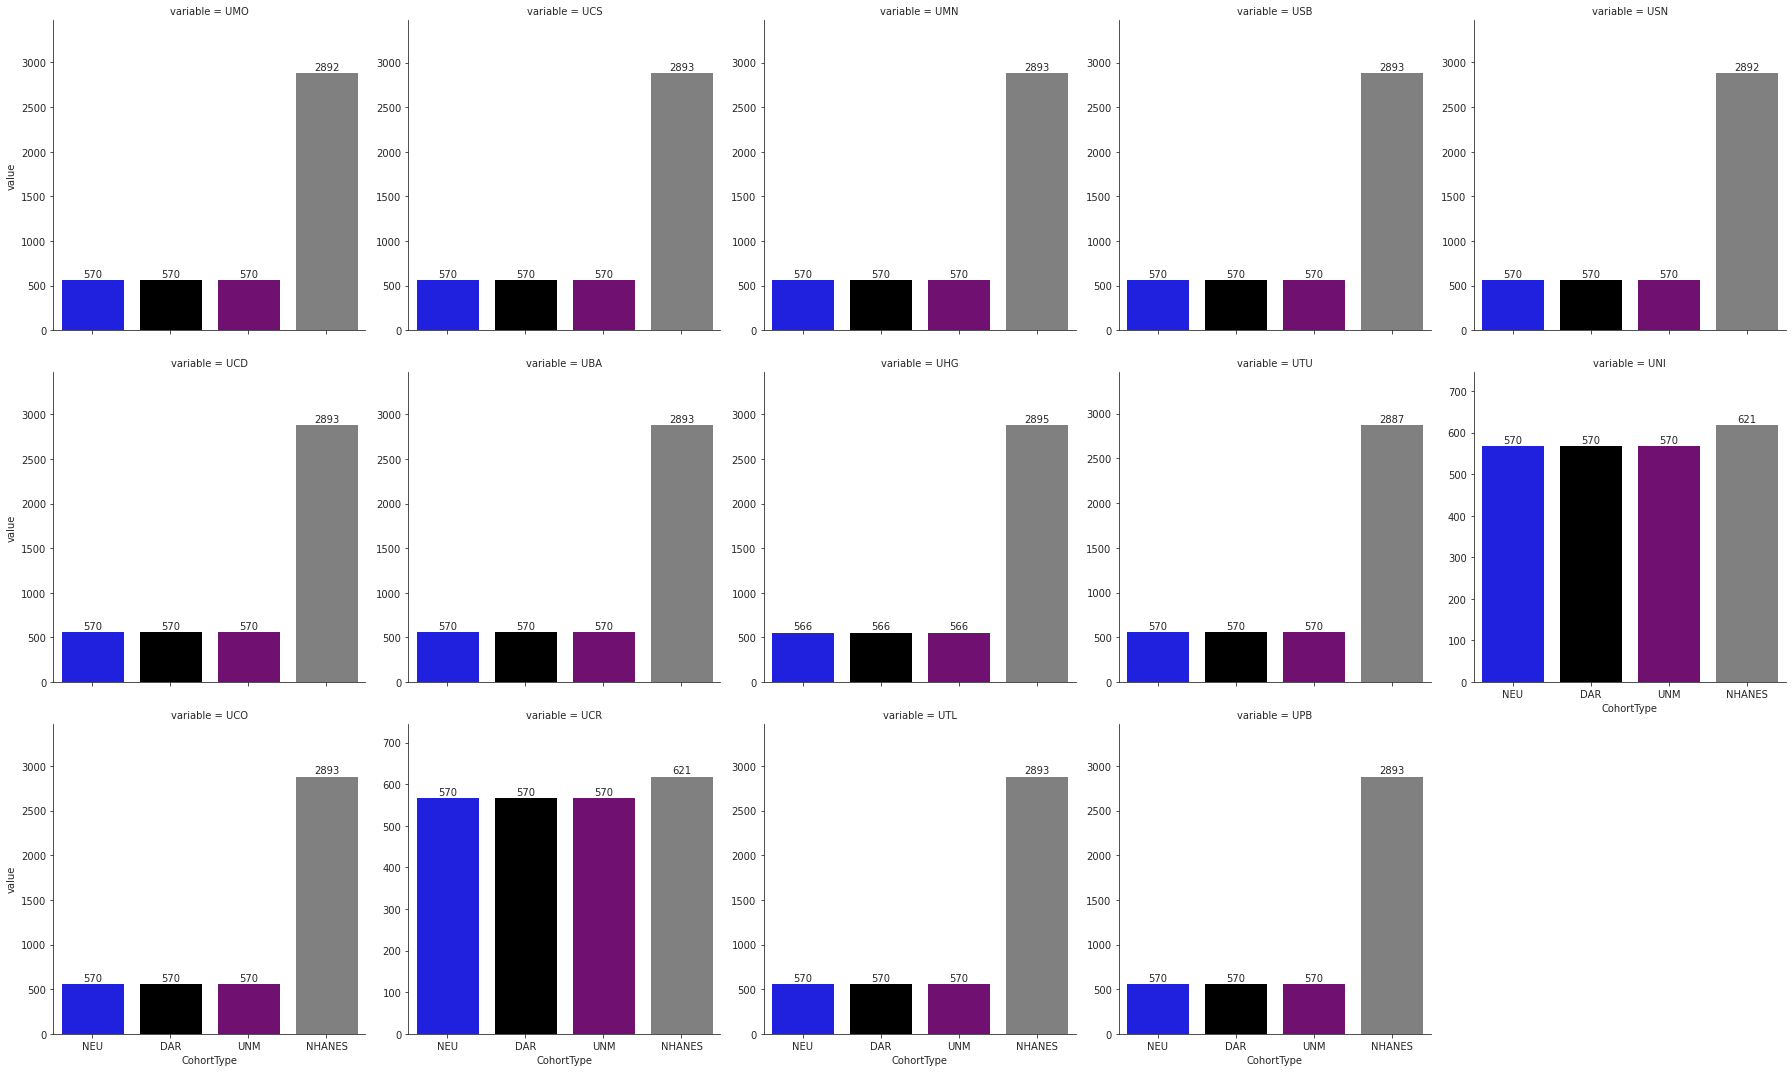

In [12]:
counts_melted = pd.melt(counts, id_vars = ['CohortType'])
hist(counts_melted, ['blue', 'black', 'purple', 'gray'], 'Analyte_Counts_Hist_DP_Paper.jpg')

**Creating Graph of Distributions**

In [14]:
##creating dataframe to create a boxplot
def long_on_analyte(df_neu, df_dar, df_unm, df_nhanes, intersec_cols):
    cols = intersec_cols
    cols.remove('PIN_Patient')
    cols.remove('TimePeriod')
    neu_ints_melt = pd.melt(df_neu[cols], id_vars = "CohortType")
    dar_ints_melt = pd.melt(df_dar[cols], id_vars = "CohortType")
    unm_ints_melt = pd.melt(df_unm[cols], id_vars = "CohortType")
    nhanes_ints_melt = pd.melt(df_nhanes[cols], id_vars = "CohortType")
    return pd.concat([neu_ints_melt, dar_ints_melt, unm_ints_melt, nhanes_ints_melt], axis = 0)

In [15]:
all_combined_stacks_melts = long_on_analyte(df_NEU, df_DAR, df_UNM, df_NHANES, intersec_cols)
all_combined_stacks_melts

,CohortType,variable,value
0,NEU,UMO,100.401
1,NEU,UMO,105.904
2,NEU,UMO,79.334
3,NEU,UMO,41.023
4,NEU,UMO,69.676
...,...,...,...
120157,NHANES,UPB,NaN
120158,NHANES,UPB,NaN
120159,NHANES,UPB,0.170
120160,NHANES,UPB,0.550


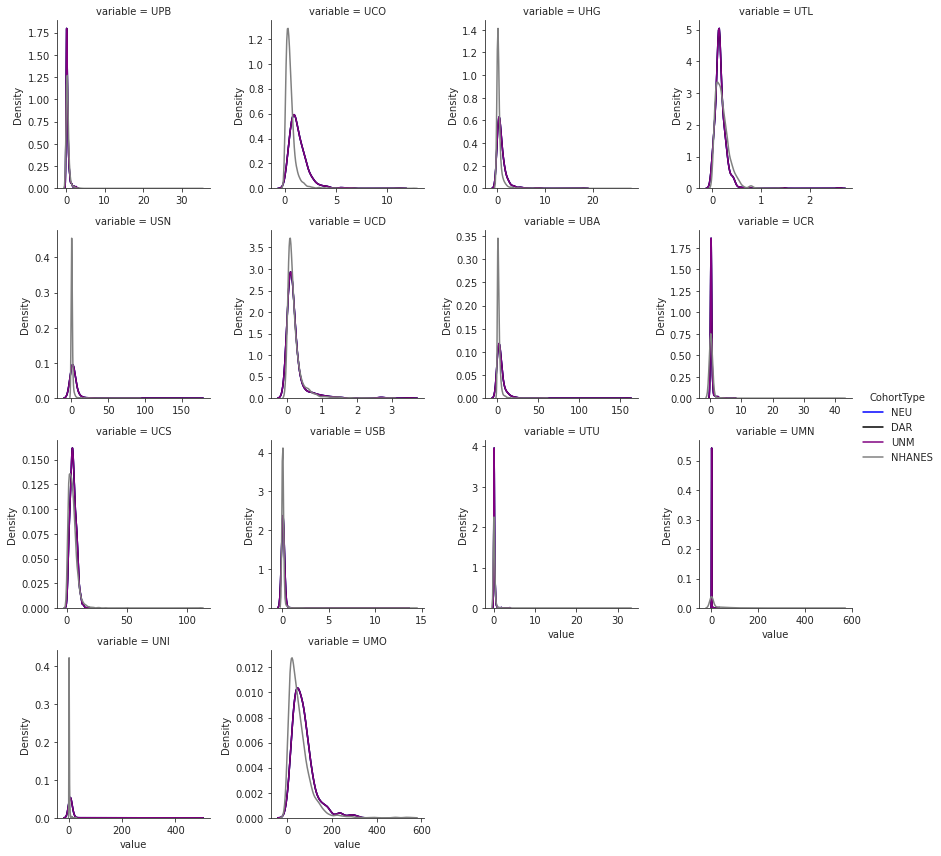

In [15]:
# Distribution Plot

g = sns.FacetGrid(all_combined_stacks_melts, col = 'variable', hue = 'CohortType', col_wrap = 4, sharex = False, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])
p1 = g.map(sns.kdeplot, 'value').add_legend()
p1.savefig('Dist_Plot_DP_Paper.jpg', format = 'jpeg', dpi = 1000)


**Creating Boxplots**

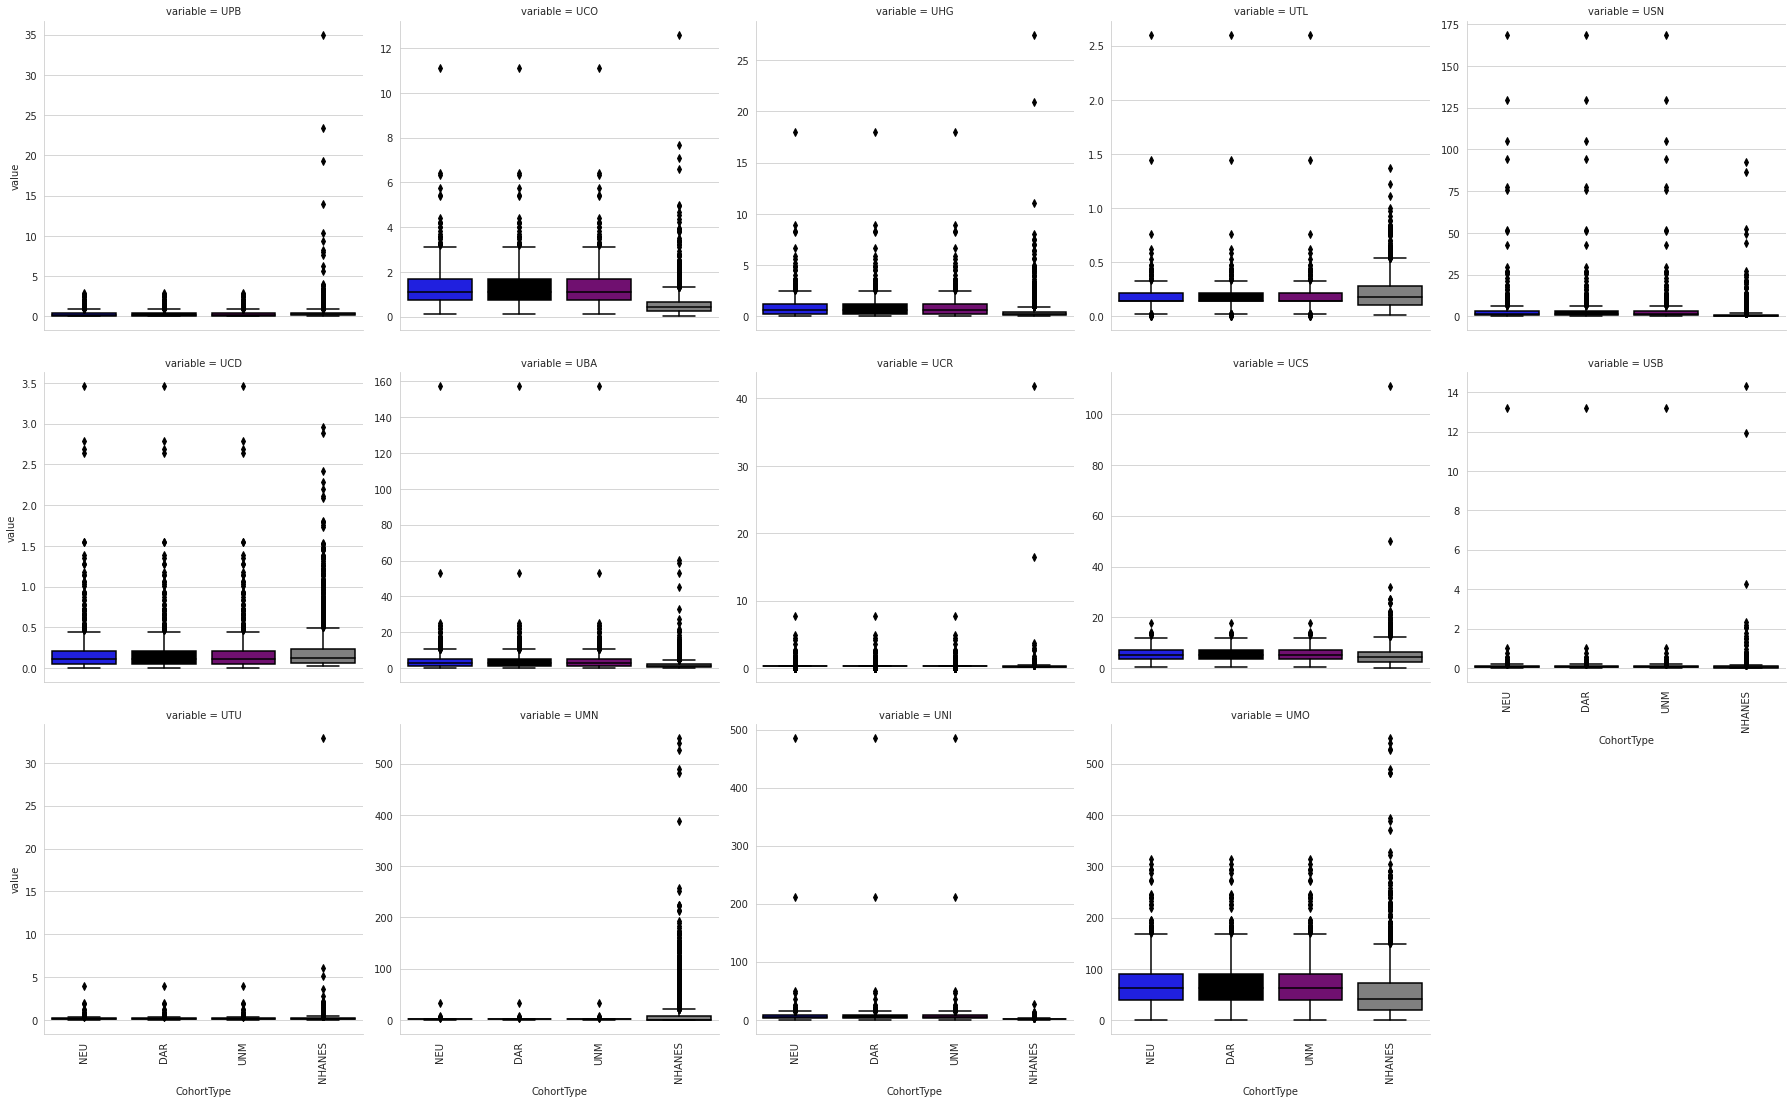

In [16]:
sns.set_style('whitegrid')

plot_df = all_combined_stacks_melts[all_combined_stacks_melts['CohortType'].isin(['NEU','DAR','UNM', 'NHANES'])]
g = sns.catplot(
    data = plot_df,
    x = 'CohortType', y ='value',
    col ='variable', kind ='box', col_wrap = 5, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])

# set rotation
g.set_xticklabels(rotation=90)

##JAG TO DO add number of data points above each box

# Calculate number of obs per group & median to position labels


for ax in g.axes.ravel():
    for c in ax.containers:
        medians = plot_df.groupby(['CohortType', 'variable'])['value'].median().values
        nobs = plot_df['value'].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]

        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick],
                    medians[tick] + 0.03,
                    nobs[tick],
                    horizontalalignment ='center',
                    size = 'x-small',
                    color ='w',
                    weight = 'semibold')

g.savefig('Boxplots_DP_Paper.jpg', format = 'jpeg', dpi = 1300)

**BLOD Bar Graphs**

In [16]:
##returns a count of how many above limit of dection values per analyte
def count_blod(df):
    cohs = []
    var = []
    val = []
    for col in df.columns:
        if col not in ['Analyte', 'PIN_Patient', 'TimePeriod', 'Member_c', 'Outcome', 'CohortType']:
            cohs.append(df['CohortType'][0])
            var.append(col)
            ##less than 0.01 becaue NHANES has 0.00000001 to mean 0.0
            val.append(df[df[col] < 0.01]['PIN_Patient'].nunique())
    return pd.DataFrame({'CohortType' : cohs, 'variable' : var, 'value' : val})
        

In [34]:
df_NEU_blod_count = count_blod(df_NEU_blod)
df_DAR_blod_count = count_blod(df_DAR_blod)
df_UNM_blod_count = count_blod(df_UNM_blod)
df_NHANES_blod_count = count_blod(df_NHANES_blod)


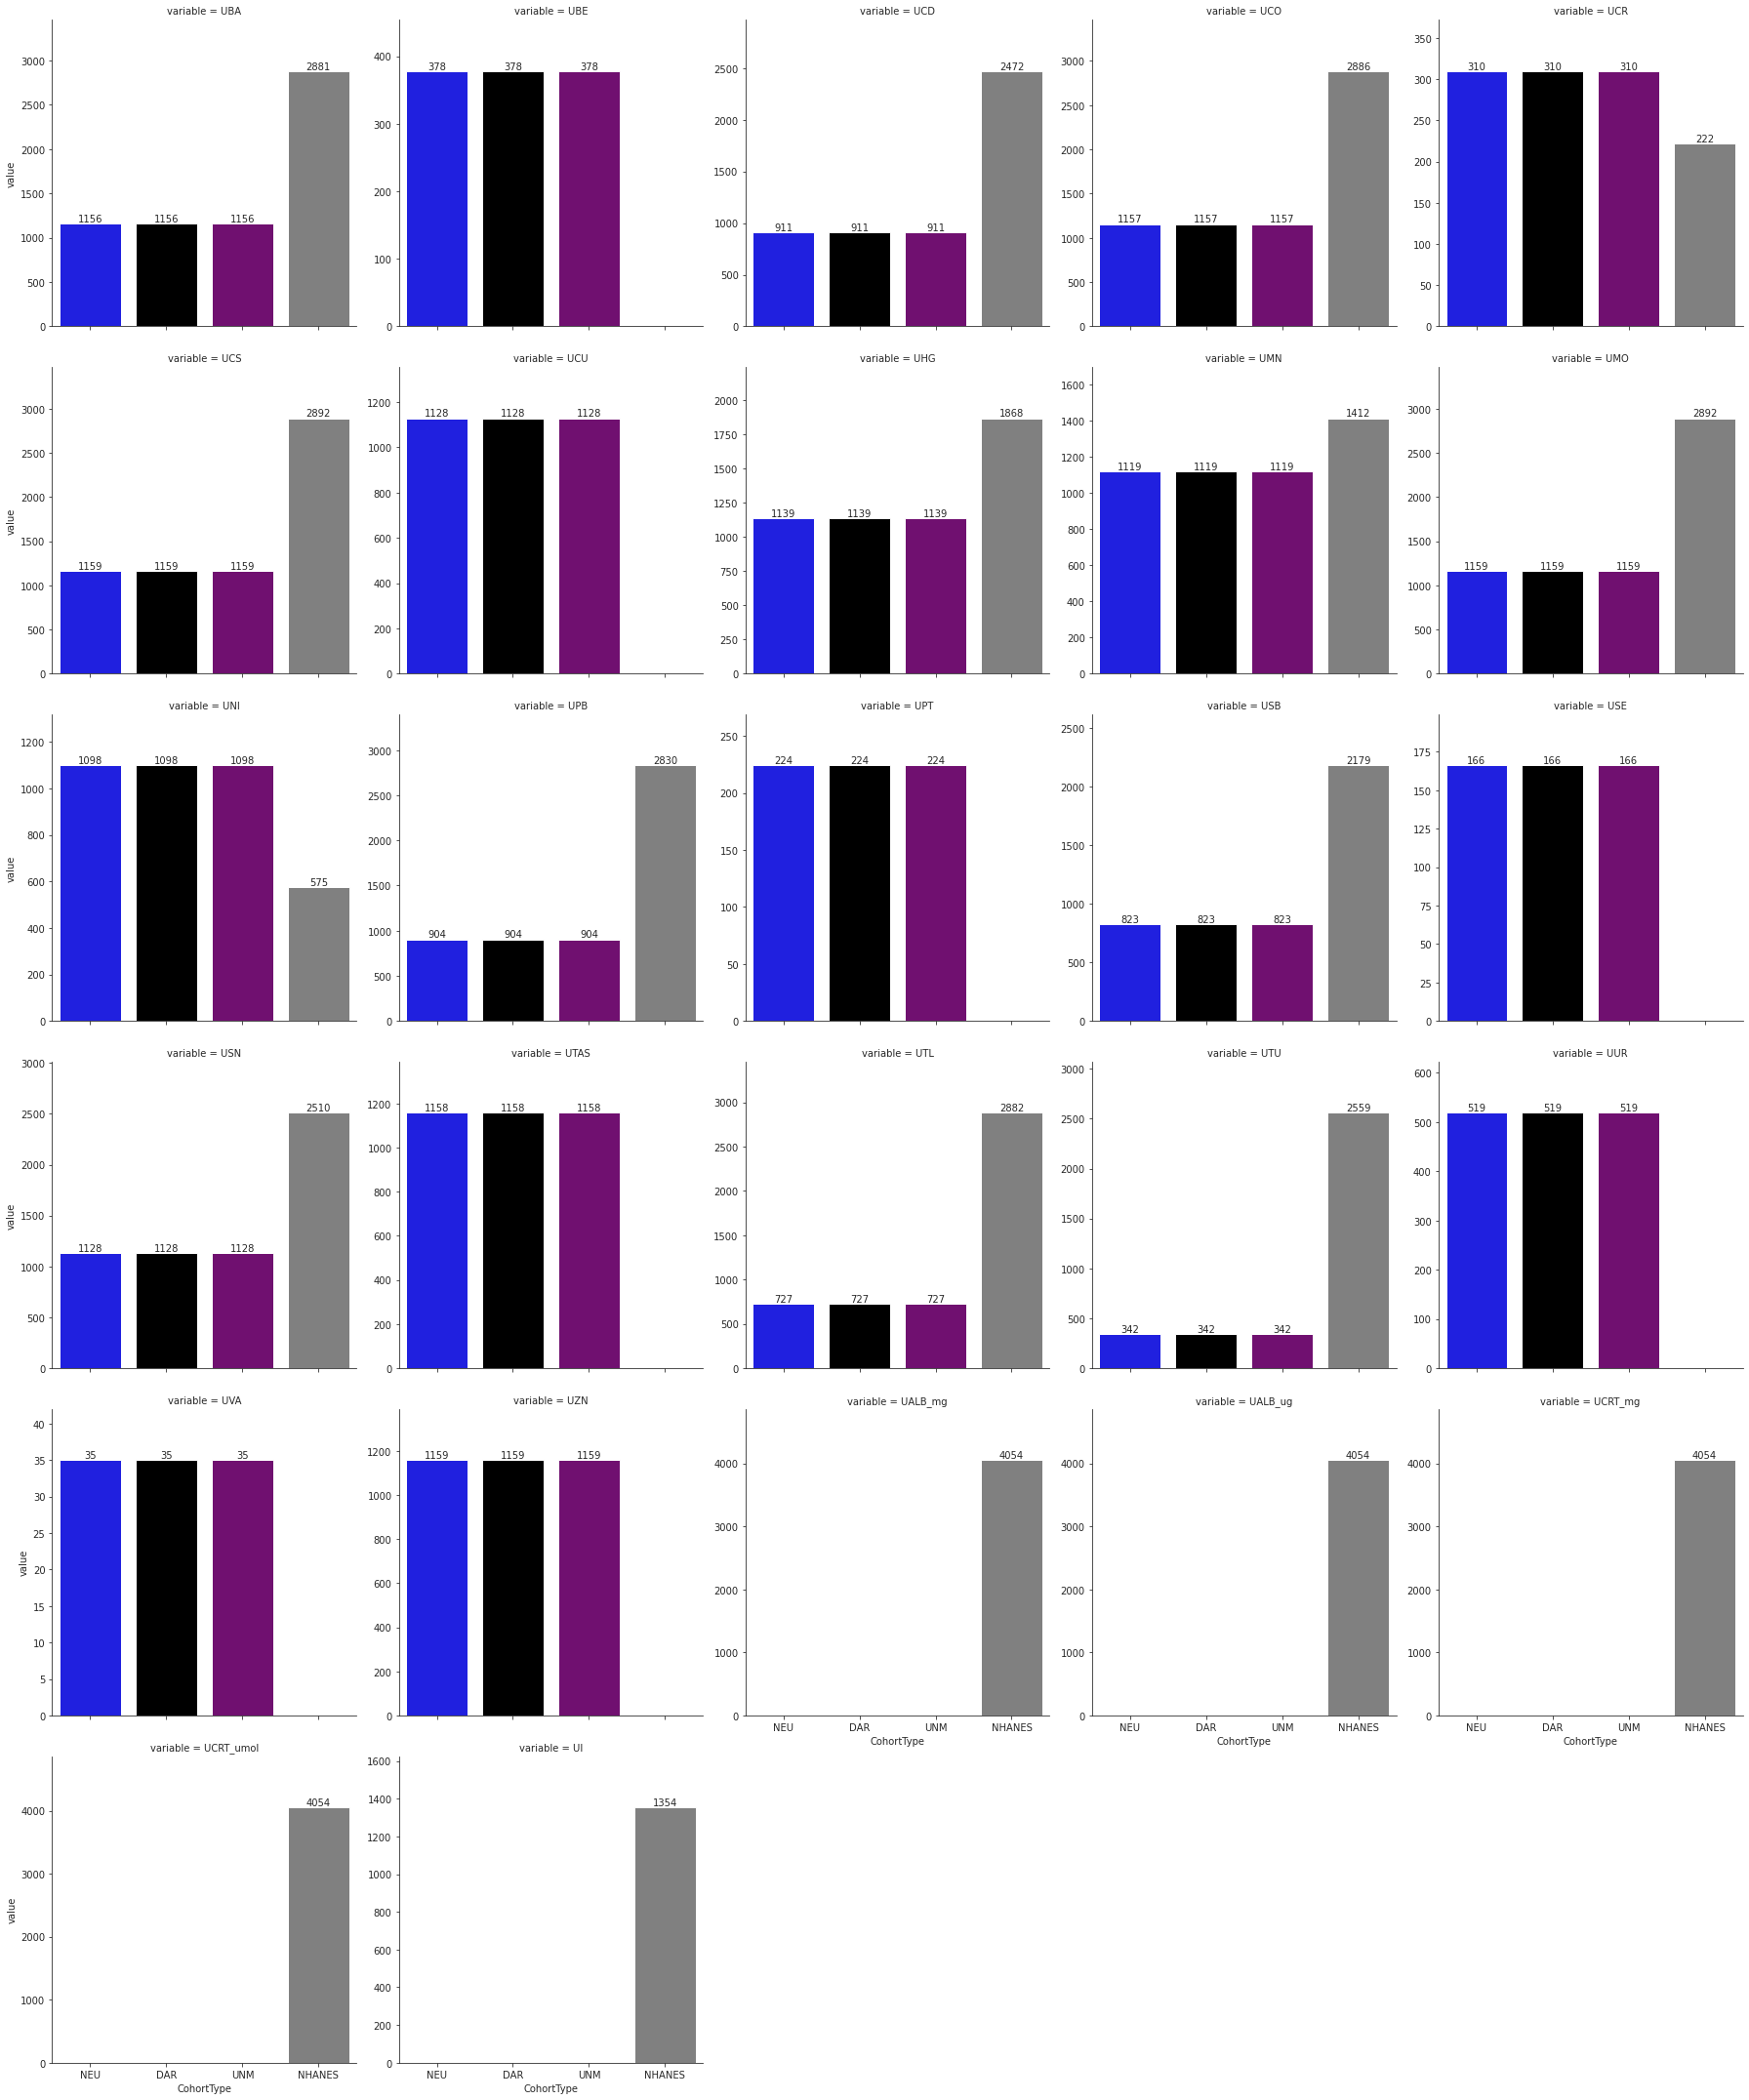

In [35]:
import seaborn as sns
all_combined_blod = pd.concat([df_NEU_blod_count, df_DAR_blod_count, df_UNM_blod_count, df_NHANES_blod_count])

hist(all_combined_blod, ['blue', 'black', 'purple', 'gray'], 'Blod_Hist_DP_Paper.jpg')


**TODO**

**1. box plots**

2. finsih other stats test
3. bar plot lod's

**One-Way Anova of Geometric Means**

Meeting assumptions

1. Normally distributed: over 30 datapoints so Central Limit Theorem says they are normally distributed
2. Independent Groups: met by structure of data
3. Homogeneity of Variances (equal variances): will be tested for each analyte group

Source: https://online.stat.psu.edu/stat200/lesson/10/10.2

In [38]:
import statistics as stat
from scipy.stats import f_oneway
from statistics import variance

##get colors to print in color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

##conduct a one way anova of all analytes
def one_way_anova(df_all):
    ##define lists that report results of anova
    analytes = []
    assumptions = []
    p_vals = []
    sig = []

    for col in df_ALL.columns:
        if col not in ['TimePeriod', 'CohortType', 'PIN_Patient']:
            analytes.append(col)
            ##get series of analyte values w/out NaN
            NEU = df_ALL[df_ALL['CohortType'] == 'NEU'][col].dropna()
            UNM = df_ALL[df_ALL['CohortType'] == 'UNM'][col].dropna()
            DAR = df_ALL[df_ALL['CohortType'] == 'DAR'][col].dropna()
            NHANES = df_ALL[df_ALL['CohortType'] == 'NHANES'][col].dropna()
            stds = [stat.stdev(NEU), stat.stdev(DAR), stat.stdev(UNM), stat.stdev(NHANES)]
            ##if equal variances, conduct anova
            ##if round(variance(NEU), 2) == round(variance(UNM), 2) == round(variance(DAR), 2) == round(variance(NHANES), 2):
            if max(stds) / min(stds) < 2:
                    assumptions.append(True)
                    #perform one-way ANOVA
                    p = f_oneway(NEU , UNM ,DAR , NHANES).pvalue
                    p_vals.append(p)
                    if p > 0.05:
                        sig.append(False)
                    else:
                        sig.append(True)
                    print(bcolors.OKGREEN + col, "passes assumptions" + bcolors.OKGREEN, '\n')



            ##if unequal variances, do not conduct anova
            else:
                    assumptions.append(False)
                    p_vals.append(np.NaN)
                    sig.append(np.NaN)
                    print(bcolors.FAIL + col, "fails: unequal variances" + bcolors.FAIL)
                    print(round(variance(NEU), 2), round(variance(UNM), 2), round(variance(DAR), 2), round(variance(NHANES), 2) , '\n')
    ##make df from results of anova
    data = {'Analytes' : analytes, 'Passes' : assumptions, 'P-Value' : p_vals, 'Significant' : sig}
    return pd.DataFrame(data)

In [39]:
anova_df = one_way_anova(df_ALL)
anova_df

UMO passes assumptions 

UCS passes assumptions 

UMN fails: unequal variances
2.3 2.3 2.3 1477.0 

USB passes assumptions 

USN fails: unequal variances
153.35 153.35 153.35 11.6 

UCD passes assumptions 

UBA fails: unequal variances
63.01 63.01 63.01 9.12 

UHG passes assumptions 

UTU fails: unequal variances
0.05 0.05 0.05 0.44 

UNI fails: unequal variances
499.63 499.63 499.63 3.32 

UCO passes assumptions 

UCR fails: unequal variances
0.32 0.32 0.32 3.31 

UTL passes assumptions 

UPB fails: unequal variances
0.17 0.17 0.17 1.09 



,Analytes,Passes,P-Value,Significant
0,UMO,True,2.194844e-29,True
1,UCS,True,2.794088e-07,True
2,UMN,False,NaN,NaN
3,USB,True,5.668653e-01,False
4,USN,False,NaN,NaN
5,UCD,True,8.953400e-01,False
6,UBA,False,NaN,NaN
7,UHG,True,8.092685e-52,True
8,UTU,False,NaN,NaN
9,UNI,False,NaN,NaN


In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

##Look to see if a valid post hoc test is jsut a t-test

##post hoc tests on analytes that were found to be significantly different by ANOVA
##if p < 0.05,there is a statistically significant difference in means
def tukey(df_neu, df_dar, df_unm, df_nhanes, cols_to_test):
    for col in cols_to_test:
        NEU = df_ALL[df_ALL['CohortType']=='NEU'].dropna(subset = [col])
        DAR = df_ALL[df_ALL['CohortType']=='DAR'].dropna(subset = [col])
        UNM = df_ALL[df_ALL['CohortType']=='UNM'].dropna(subset = [col])
        NHANES = df_ALL[df_ALL['CohortType']=='NHANES'].dropna(subset = [col])
        df = pd.concat([NEU, DAR, UNM, NHANES])
        tukey = pairwise_tukeyhsd(endog = df[col],
                                  groups = df['CohortType'],
                                  alpha=0.05)
        file_name = 'tukey_results.csv'
        try:
            f = open(file_name, 'x')
            f = open(file_name, 'x')

        except:
            f = open(file_name, 'a')
            f.write(col + ' Tukey Result: \n')
            f.write(str(tukey))
            f.write('\n\n')

        f.close()

In [41]:
cols_to_test = anova_df[anova_df['Passes'] == True]['Analytes']
tukey(df_NEU, df_DAR, df_UNM, df_NHANES, cols_to_test)

**Kolmogorov-Smirnov Test**

Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

Note: Has this assumption been met - "Perhaps the most serious limitation is that the distribution must be fully specified. That is, if location, scale, and shape parameters are estimated from the data, the critical region of the K-S test is no longer valid. It typically must be determined by simulation."

In [33]:
 def ks_test_helper1(df_all, coh, col_to_test, coh_acc, analyte_acc, dist_acc, p_acc):
    weib = np.random.weibull(1, 1000)
    norm =  np.random.normal(0, 1, 1000)
    for col in cols_to_test:
        ##p < 0.05, data does NOT follow that distribution
        ##alternative option set to two sided means null hypothesis is that d1 = d2
        
        ##Normal
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('normal')
        p_val = kstest(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       norm, alternative = 'two-sided').pvalue
        p_acc.append(p_val)
        
    for col in cols_to_test:
        ##Weibull
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('weibull')
        p_val = kstest(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       weib, alternative = 'two-sided').pvalue
        p_acc.append(p_val)
    
    return coh_acc, analyte_acc, dist_acc, p_acc

##determining if two samples came from the same distribution
##determining what distribution a sample follows
def ks_test_helper2(df_all, coh, col_to_test, coh_acc, analyte_acc, dist_acc, p_acc):
    from scipy.stats import ks_2samp
    weib = np.random.weibull(1, 1000)
    norm =  np.random.normal(0, 1, 1000)
    for col in cols_to_test:
        ##p < 0.05, data does NOT follow that distribution
        ##alternative option set to two sided means null hypothesis is that d1 = d2
        
        ##Normal
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('normal')
        p_val = ks_2samp(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       norm).pvalue
        p_acc.append(p_val)
        
    for col in cols_to_test:
        ##Weibull
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('weibull')
        p_val = ks_2samp(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       weib).pvalue
        p_acc.append(p_val)
    
    return coh_acc, analyte_acc, dist_acc, p_acc
##p < 0 .05, two samples DO NOT come from the same distribution


In [49]:
##determining what distribution a sample follows
from scipy.stats import kstest

def ks_test1(df_all, cols_to_test):
    ##NEU
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper1(df_ALL, 'NEU', cols_to_test, [], [], [], [])
    
    ##DAR
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper1(df_ALL, 'DAR', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)

    ##UNM
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper1(df_ALL, 'UNM', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)

    ##NHANES
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper1(df_ALL, 'NHANES', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)
       
    return pd. DataFrame(data = {'cohort' : coh_acc, 'analyte' : analyte_acc, 'distribution comapred to' : dist_acc, 'p-value' : p_acc})
def ks_test2(df_all, cols_to_test):
    ##NEU
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper2(df_ALL, 'NEU', cols_to_test, [], [], [], [])
    
    ##DAR
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper2(df_ALL, 'DAR', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)

    ##UNM
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper2(df_ALL, 'UNM', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)

    ##NHANES
    coh_acc, analyte_acc, dist_acc, p_acc = ks_test_helper2(df_ALL, 'NHANES', cols_to_test,  coh_acc, analyte_acc, dist_acc, p_acc)
       
    return pd. DataFrame(data = {'cohort' : coh_acc, 'analyte' : analyte_acc, 'distribution comapred to' : dist_acc, 'p-value' : p_acc})

In [61]:
df_ks1 = ks_test1(df_ALL, cols_to_test)
df_ks1['distribution matches'] = df_ks1['p-value'].map(lambda p : p > 0.05 )
df_ks1.head(5)
df_ks2 = ks_test2(df_ALL, cols_to_test)
df_ks2['distribution matches'] = df_ks2['p-value'].map(lambda p : p > 0.05 )

In [62]:
df_ks1[df_ks1['distribution matches'] == True]

,cohort,analyte,distribution comapred to,p-value,distribution matches
39,UNM,UHG,weibull,0.098905,True


In [52]:
df_ks2[df_ks2['distribution matches'] == True]

,cohort,analyte,distribution comapred to,p-value,distribution matches


In [ ]:
##determining if two samples came from the same distribution
##determining what distribution a sample follows
from scipy.stats import ks_2samp
weib = np.random.weibull(1, 100)
norm =  np.random.normal(0, 1, 100)
def ks_test_helper(df_all, coh, col_to_test, coh_acc, analyte_acc, dist_acc, p_acc):
    weib = np.random.weibull(1, 10)
    norm =  np.random.normal(0, 1, 10)
    for col in cols_to_test:
        ##p < 0.05, data does NOT follow that distribution
        ##alternative option set to two sided means null hypothesis is that d1 = d2
        
        ##Normal
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('normal')
        p_val = ks_2samp(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       norm).pvalue
        p_acc.append(p_val)
        ks_2samp(d1, d2).pvalue
        
    for col in cols_to_test:
        ##Weibull
        coh_acc.append(coh)
        analyte_acc.append(col)
        dist_acc.append('weibull')
        p_val = ks_2samp(df_ALL[df_ALL['CohortType']==coh].dropna(subset = [col])[col],
                       weib).pvalue
        p_acc.append(p_val)
    
    return coh_acc, analyte_acc, dist_acc, p_acc
##p < 0 .05, two samples DO NOT come from the same distribution


In [ ]:
df_ks = ks_test(df_ALL, cols_to_test)
df_ks['distribution matches'] = df_ks['p-value'].map(lambda p : p > 0.05 )
df_ks

In [ ]:
import scipy.stats as stats
# Creation of data
d1 = df_ALL[df_ALL['CohortType']=='NEU'].dropna(subset = ['UTL'])['UTL']

# significance level
alpha = 0.05

# Calcualtion of Chisquare
from scipy.stats import chisquare
chisquare(d1)

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, df['Varname'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)


In [ ]:
data = [['CDU', 0.415, 57], ['SPD', 0.257, 26], ['Others', 0.328, 40]] 
df = pd.DataFrame(data, columns = ['Varname', 'prob_dist', 'observed_freq']) 
df['expected_freq'] = df['observed_freq'].sum() * df['prob_dist']